In [18]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/My\ Drive/tmp/speech2 -r ./
%cd speech2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/speech2/speech2


In [0]:
!unzip -q data.zip

In [0]:
!unzip -q noised.zip

In [0]:
import librosa
import numpy as np
import scipy.io.wavfile as wav
import IPython.display as ipd
import matplotlib.pyplot as plt

from laughter_prediction.feature_extractors import FeatureExtractor
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler

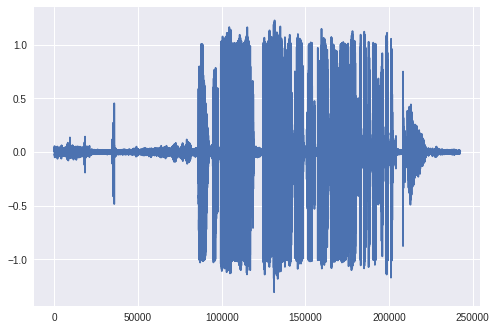

In [22]:
audio, sr = librosa.core.load('data/data/S0002.wav')
plt.plot(audio)
plt.show();
ipd.Audio(audio, rate=sr)

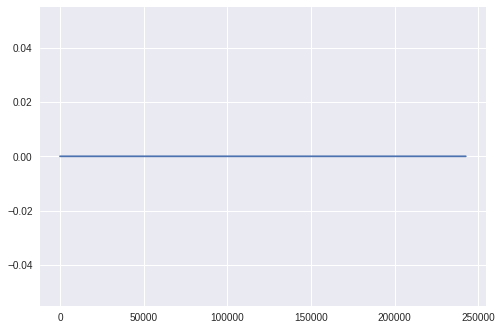

In [0]:
audio_noised, _ = librosa.core.load('vocalizationcorpus/data/S0002.wav')
plt.plot(audio - audio_noised)
plt.show();

In [0]:
import os

noise, _ = librosa.core.load('noise.wav', sr)
for file in os.listdir("data/data"):
    audio, sr = librosa.core.load("data/data/" + file)
    if len(noise) > len(audio):
        noise = noise[:len(audio)]
    else:
        while len(noise) < len(audio): # loop in case noise is shorter than 
            noise = np.concatenate((noise, noise), axis=0)
        noise = noise[:len(audio)]
    audio_noised = audio + 0.1 * noise
    librosa.output.write_wav('noisy_data/data/' + file, audio_noised, sr)

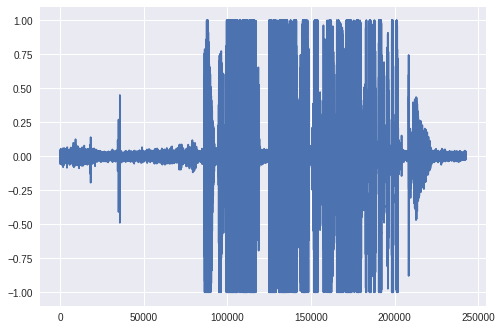

In [0]:
audio_noised, _ = librosa.core.load('noisy_data/data/S0002.wav')
plt.plot(audio_noised)
plt.show();

In [23]:
data = SSPNetDataSampler('data/').create_sampled_df(0.7, save_path='samples.csv')

saving df:  samples.csv


In [0]:
data_noisy = SSPNetDataSampler('noisy_data/').create_sampled_df(0.7, save_path='samples_noisy.csv')

In [0]:
data.head()

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,fbank_120,fbank_121,fbank_122,fbank_123,fbank_124,fbank_125,fbank_126,fbank_127,IS_LAUGHTER,SNAME
0,-334.740355,111.401952,-70.091592,93.037492,-57.066990,42.645603,-22.057309,11.085152,-13.530613,10.412845,...,-24.704173,-25.072859,-25.437510,-25.570685,-25.621442,-25.564961,-25.867252,-26.381221,0,S1182
1,-271.581996,116.563107,-89.525989,80.406063,-58.571126,39.530980,-24.876286,1.776674,-14.651830,10.277615,...,-23.741784,-24.313584,-24.704330,-24.950381,-25.437498,-25.785896,-26.274935,-26.845317,0,S1182
2,-322.180215,108.006623,-60.008009,74.018223,-56.378040,39.313330,-12.722125,8.383743,-9.394192,10.028287,...,-23.837766,-24.136551,-24.359128,-24.450249,-24.483783,-24.449529,-24.594889,-25.046929,0,S1182
3,-262.547576,133.395704,-17.974323,41.694985,-52.267318,46.567462,-1.314356,-13.637307,-8.107539,-2.844502,...,-22.971485,-23.132684,-23.234371,-23.271913,-23.322752,-23.297158,-23.655127,-23.964239,0,S1182
4,-182.028281,151.421091,-23.005343,63.298401,-25.265986,35.096385,-22.224774,-14.820100,2.119961,-3.226670,...,-21.411215,-21.545294,-21.743760,-21.844923,-22.028620,-22.086753,-22.332175,-22.700133,0,S1182


In [0]:
print(len(data))

202390


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):

    def __init__(self, mfcc_len, fbank_len, hidden_len=128):
        super(Model, self).__init__()
        self.mfcc_len = mfcc_len
        self.fbank_len = fbank_len
        self.mfcc = nn.LSTM(mfcc_len, hidden_len)
        self.tmp = nn.LSTM(mfcc_len+fbank_len, hidden_len)
        self.fbank = nn.LSTM(fbank_len, hidden_len)
        self.predict = nn.Linear(2 * hidden_len, 2)

    def forward(self, features):
        res_mfcc, _ = self.mfcc(features[:, :, :self.mfcc_len])
        res_fbank, _ = self.fbank(features[:, :, self.mfcc_len:])
        res = torch.cat((res_mfcc, res_fbank), dim=2)
        res = F.log_softmax(self.predict(res), dim=-1)

        return res

In [0]:
from sklearn.model_selection import train_test_split

def prepare_data(dataset):
    feat_len = dataset.shape[1] - 2
    sname_len = len(dataset[dataset.SNAME == dataset.iloc[0,-1]])
    fbank_len = dataset.columns.str.contains('fbank').sum()
    mfcc_len = feat_len - fbank_len
    print("Features size", feat_len)
    print("Sname size", sname_len)
    print("Fbank size", fbank_len)
    print("Mfcc size", mfcc_len)
    
    feats = dataset.copy()
    feats['id'] = range(1, len(feats) + 1)
    feats.set_index(['SNAME', 'id'], inplace=True)
    feats.head()
    
    id_train, id_test = train_test_split(dataset['SNAME'].unique(), test_size=0.2)
    data_train = np.array(feats.loc[id_train])
    data_test = np.array(feats.loc[id_test])
    n_train, n_test = len(id_train), len(id_test)

    x_train = data_train[:, :-1].reshape(n_train, sname_len, feat_len)
    y_train = data_train[:, -1].reshape(n_train, sname_len)
    x_test = data_test[:, :-1].reshape(n_test, sname_len, feat_len)
    y_test = data_test[:, -1].reshape(n_test, sname_len)
    print("x_train", x_train.shape)
    print("y_train", y_train.shape)
    print("x_test", x_test.shape)
    print("y_test", y_test.shape)
    
    return x_train, y_train, x_test, y_test

Clean sound

In [39]:
x_train, y_train, x_test, y_test = prepare_data(data)

Features size 148
Sname size 74
Fbank size 128
Mfcc size 20
x_train (2188, 74, 148)
y_train (2188, 74)
x_test (547, 74, 148)
y_test (547, 74)


In [0]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score

model = Model(mfcc_len, fbank_len)
loss = nn.NLLLoss()
optimize = optim.SGD(model.parameters(), lr=0.01)
labs_train = torch.tensor(y_train, dtype=torch.long).reshape(-1)
labs_test = torch.tensor(y_test, dtype=torch.long).reshape(-1)

In [0]:
loss_train = []
loss_test = []
auc_train = []
auc_test = []
for it in range(70):
    print('Iter:', it)

    model.train()
    model.zero_grad()
    labs = model(torch.tensor(x_train, dtype=torch.float))

    l = loss(labs.reshape(-1, 2), labs_train)
    l.backward()
    optimize.step()
    l = l.item()
    loss_train.append(l)
    print("Train loss =", l)
    auc = roc_auc_score(labs_train, labs.detach().reshape(-1, 2)[:, 1])
    auc_train.append(auc)
    print("Train auc =", auc)

    with torch.no_grad():
        model.eval()
        labs = model(torch.tensor(x_test, dtype=torch.float))
        l = loss(labs.reshape(-1, 2), labs_test)
        l = l.item()
        loss_test.append(l)
        print("Test loss =", l)
        auc = roc_auc_score(labs_test, labs.detach().reshape(-1, 2)[:, 1])
        auc_test.append(auc)
        print("Test auc =", auc)
        

Iter: 0
Train loss = 0.30624455213546753
Train auc = 0.6549229867636761
Test loss = 0.2527643144130707
Test auc = 0.6483549999422289
Iter: 1
Train loss = 0.25861799716949463
Train auc = 0.6597261730837276
Test loss = 0.22311051189899445
Test auc = 0.651405212282108
Iter: 2
Train loss = 0.2299845665693283
Train auc = 0.6611107563997728
Test loss = 0.20117707550525665
Test auc = 0.653084486804214
Iter: 3
Train loss = 0.20737086236476898
Train auc = 0.6642936236531456
Test loss = 0.1857701987028122
Test auc = 0.6554052141568669
Iter: 4
Train loss = 0.1946888417005539
Train auc = 0.6650739238115266
Test loss = 0.17700736224651337
Test auc = 0.6550046474661604
Iter: 5
Train loss = 0.18675273656845093
Train auc = 0.6644006507302987
Test loss = 0.1702761948108673
Test auc = 0.654596551173164
Iter: 6
Train loss = 0.18073344230651855
Train auc = 0.6639039739639158
Test loss = 0.16497184336185455
Test auc = 0.6542589723056744
Iter: 7
Train loss = 0.17604227364063263
Train auc = 0.663530041458918

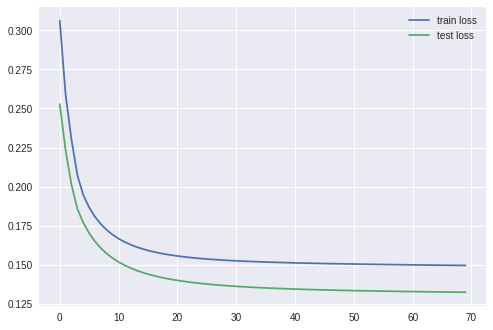

In [0]:
m = len(loss_train)
plt.plot(range(m), loss_train)
plt.plot(range(m), loss_test)
plt.legend(['train loss', 'test loss'])
plt.show()

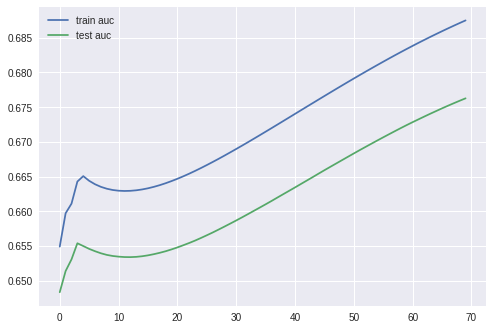

In [0]:
plt.plot(range(m), auc_train)
plt.plot(range(m), auc_test)
plt.legend(['train auc', 'test auc'])
plt.show()

Noisy sound

In [35]:
x_train_noisy, y_train_noisy, x_test_noisy, y_test_noisy = prepare_data(data_noisy)
feat_len = data_noisy.shape[1] - 2
fbank_len = data_noisy.columns.str.contains('fbank').sum()
mfcc_len = feat_len - fbank_len

Features size 148
Sname size 74
Fbank size 128
Mfcc size 20
x_train (2188, 74, 148)
y_train (2188, 74)
x_test (547, 74, 148)
y_test (547, 74)


In [0]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score

model = Model(mfcc_len, fbank_len)
loss = nn.NLLLoss()
optimize = optim.SGD(model.parameters(), lr=0.01)
labs_train = torch.tensor(y_train_noisy, dtype=torch.long).reshape(-1)
labs_test = torch.tensor(y_test_noisy, dtype=torch.long).reshape(-1)

In [40]:
labs_train_noisy = torch.tensor(y_train_noisy, dtype=torch.long).reshape(-1)
labs_test_noisy = torch.tensor(y_test_noisy, dtype=torch.long).reshape(-1)

loss_train_noisy = []
loss_test_noisy = []
auc_train_noisy = []
auc_test_noisy = []
for it in range(70):
    print('Iter:', it)

    model.train()
    
    model.zero_grad()
    labs = model(torch.tensor(x_train, dtype=torch.float))
    l = loss(labs.reshape(-1, 2), labs_train)
    l.backward()
    optimize.step()
    
    model.zero_grad()
    labs = model(torch.tensor(x_train_noisy, dtype=torch.float))
    l = loss(labs.reshape(-1, 2), labs_train_noisy)
    l.backward()
    optimize.step()
    l = l.item()
    loss_train_noisy.append(l)
    print("Train loss =", l)
    auc = roc_auc_score(labs_train_noisy, labs.detach().reshape(-1, 2)[:, 1])
    auc_train_noisy.append(auc)
    print("Train auc =", auc)

    with torch.no_grad():
        model.eval()
        labs = model(torch.tensor(x_test_noisy, dtype=torch.float))
        l = loss(labs.reshape(-1, 2), labs_test_noisy)
        l = l.item()
        loss_test_noisy.append(l)
        print("Test loss =", l)
        auc = roc_auc_score(labs_test_noisy, labs.detach().reshape(-1, 2)[:, 1])
        auc_test_noisy.append(auc)
        print("Test auc =", auc)

Iter: 0
Train loss = 0.38380005955696106
Train auc = 0.47553896958658437
Test loss = 0.2963818907737732
Test auc = 0.5237022158849141
Iter: 1
Train loss = 0.2500256896018982
Train auc = 0.566371042409282
Test loss = 0.22355903685092926
Test auc = 0.5692337062650523
Iter: 2
Train loss = 0.20540907979011536
Train auc = 0.5983236149779725
Test loss = 0.19390776753425598
Test auc = 0.5876865733119574
Iter: 3
Train loss = 0.1847732663154602
Train auc = 0.6123454066844933
Test loss = 0.1787295788526535
Test auc = 0.5974630918661343
Iter: 4
Train loss = 0.17340975999832153
Train auc = 0.6203300158435777
Test loss = 0.1698196977376938
Test auc = 0.6033658681515166
Iter: 5
Train loss = 0.16643281280994415
Train auc = 0.6255555612425838
Test loss = 0.1641218066215515
Test auc = 0.6074544974591072
Iter: 6
Train loss = 0.16184578835964203
Train auc = 0.6293258608082613
Test loss = 0.16026580333709717
Test auc = 0.6105146275052544
Iter: 7
Train loss = 0.15867939591407776
Train auc = 0.6322630188506

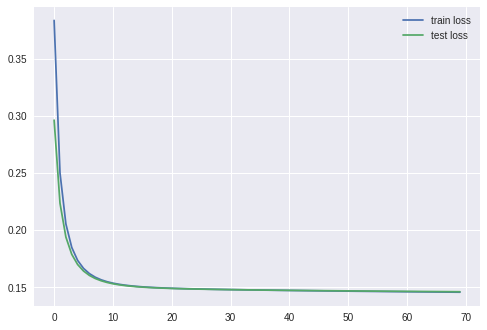

In [41]:
m = len(loss_train_noisy)
plt.plot(range(m), loss_train_noisy)
plt.plot(range(m), loss_test_noisy)
plt.legend(['train loss', 'test loss'])
plt.show()

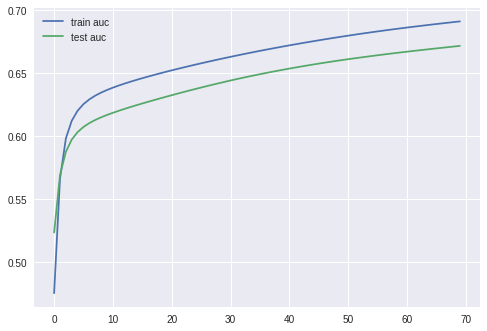

In [42]:
plt.plot(range(m), auc_train_noisy)
plt.plot(range(m), auc_test_noisy)
plt.legend(['train auc', 'test auc'])
plt.show()